# NYC Taxi Duration Prediction  
## 02. Data Sampling + Feature Engineering (One‑Hot Encoding)

This notebook mirrors **Notebook 1** and adds two light extensions:
1) **Deterministic sampling (10%)** of train/validation to speed up iteration.  
2) A quick **one‑hot encoding (OHE) deep dive** using the same `DictVectorizer` as in Notebook 1.


## Imports
- **pandas / numpy** for data wrangling  
- **scikit‑learn** `DictVectorizer`, `LinearRegression`, `RMSE`  
- **seaborn / matplotlib** for the same plots as Notebook 1


In [1]:
import warnings
import time

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Feature engineering and linear regression
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## Data Sources (Train/Validation)
Training data: **January 2024**. Validation data: **February 2024** from NYC TLC trip records.


In [2]:
TRAIN_URL = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet' # JAN 2024
VAL_URL   = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet' # FEB 2024

## Define Data Loading Function
Same as Notebook 1, with duration filtering and categorical casting for OHE.


In [4]:
# Pickup and Dropoff locations as Categorical
CATEGORICAL = ['PULocationID', 'DOLocationID']

def read_data(url: str) -> pd.DataFrame:
    # Read parquet file
    df = pd.read_parquet(url)
    
    # Duration in minutes
    df['duration'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.total_seconds() / 60
    
    # Remove outliers, keep only reasonable trips
    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()
    
    # Categorical as strings for one-hot encoding
    df[CATEGORICAL] = df[CATEGORICAL].astype(str)
    return df

In [5]:
df_train = read_data(TRAIN_URL)
df_val   = read_data(VAL_URL)

print(f"Train rows: {len(df_train):,};  Val rows: {len(df_val):,}")
df_train.head(3)

Train rows: 2,898,906;  Val rows: 2,938,060


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0,19.800000
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0,6.600000
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0,17.916667


## Optional Deterministic Sampling (10%)
Keep everything identical, just work on a smaller slice for faster iteration. Set the seed for reproducibility.


In [6]:
SAMPLE_FRAC = 0.10  # change to 1.0 to disable sampling
SEED = 42

len_train_before, len_val_before = len(df_train), len(df_val)

if SAMPLE_FRAC < 1.0:
    df_train = df_train.sample(frac=SAMPLE_FRAC, random_state=SEED)
    df_val   = df_val.sample(frac=SAMPLE_FRAC,   random_state=SEED)

print(f"Train size: {len_train_before:,} -> {len(df_train):,}")
print(f"Val   size: {len_val_before:,} -> {len(df_val):,}")

Train size: 2,898,906 -> 289,891
Val   size: 2,938,060 -> 293,806


In [7]:
# Quick sanity check similar to Notebook 1
df_train.duration.mean()

np.float64(14.434337791330764)

## Prepare Features (One‑Hot Encoding)
We use **`DictVectorizer`** (same as Notebook 1) to one‑hot encode pickup/dropoff IDs.


In [8]:
# Convert categorical columns to a list of dictionaries (one per row)
train_dicts = df_train[CATEGORICAL].to_dict(orient='records')

# Initialize the DictVectorizer for one-hot encoding
dv = DictVectorizer()

# Fit the vectorizer and transform the training data into a feature matrix
X_train = dv.fit_transform(train_dicts)

# Target variable: trip duration
y_train = df_train['duration'].values

print('Feature matrix (train):', X_train.shape)

Feature matrix (train): (289891, 491)


### OHE Quick Peek
- **How many features?** (`dv.get_feature_names_out()`)  
- **What does a single row look like after OHE?** (non‑zero features)  
- **Which categories are most common?** (top 10 bar plot for pickup IDs)


In [9]:
# Number of OHE features
feature_names = dv.get_feature_names_out()
print('Num OHE features:', len(feature_names))

# Show non-zero features for the first training example
row = 0
nz_cols = X_train[row].nonzero()[1]
decoded = [(feature_names[i], X_train[row, i]) for i in nz_cols]
pd.DataFrame(decoded, columns=['feature', 'value'])

Num OHE features: 491


,feature,value
0,DOLocationID=261,1.0
1,PULocationID=163,1.0


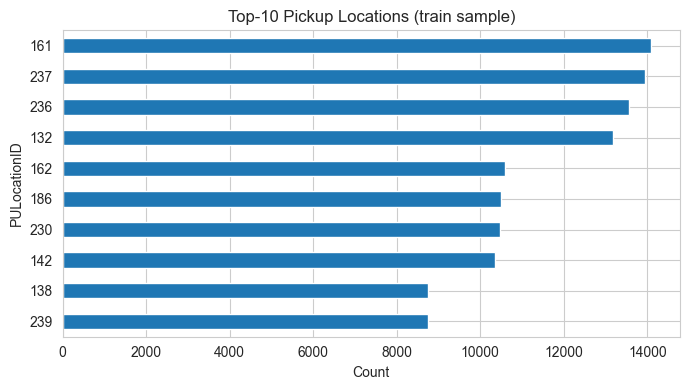

In [10]:
# Top-10 most frequent pickup locations (on sampled train)
top_pu = (df_train['PULocationID']
          .value_counts()
          .head(10)
          .sort_values(ascending=True))

plt.figure(figsize=(7,4))
top_pu.plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('PULocationID')
plt.title('Top-10 Pickup Locations (train sample)')
plt.tight_layout()

## Train Linear Regression
Identical to Notebook 1: fit **LinearRegression**, compute train RMSE, and visualize.


In [11]:
# Initialize the linear regression model
lr = LinearRegression()

# Fit the model to the training data (timing)
start_train = time.time()
lr.fit(X_train, y_train)
end_train = time.time()
train_duration = end_train - start_train

# Predict durations on the training set (timing)
start_pred = time.time()
y_pred_train = lr.predict(X_train)
end_pred = time.time()
pred_duration = end_pred - start_pred

# Calculate RMSE (Root Mean Squared Error) on the training set
rmse_train = root_mean_squared_error(y_train, y_pred_train)

# Print the training RMSE and durations
print(f"Train RMSE: {rmse_train:.3f}")
print(f"Training time: {train_duration:.2f} seconds")
print(f"Prediction time: {pred_duration:.2f} seconds")

Train RMSE: 7.924
Training time: 0.73 seconds
Prediction time: 0.00 seconds


### Quick Visual Check
Same histogram overlay for **actual vs predicted** trip durations.


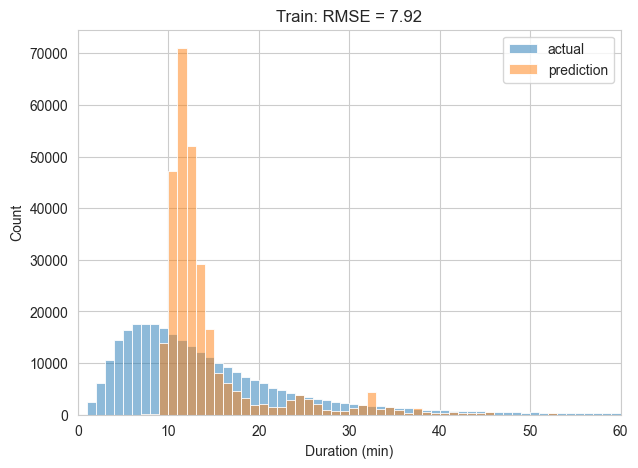

In [12]:
bins = np.arange(0, 61, 1)
plt.figure(figsize=(7,5))
sns.histplot(y_train, bins=bins, alpha=0.5, label='actual')
sns.histplot(y_pred_train, bins=bins, alpha=0.5, label='prediction')
plt.xlim(0, 60)
plt.xlabel('Duration (min)')
plt.ylabel('Count')
plt.title(f'Train: RMSE = {rmse_train:.2f}')
plt.legend();

## Validate the Model
Use the **same vectorizer** on the validation set (never `fit` on validation), predict, and report RMSE.


In [13]:
val_dicts = df_val[CATEGORICAL].to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_val = df_val['duration'].values

y_pred_val = lr.predict(X_val)
rmse_val = root_mean_squared_error(y_val, y_pred_val)
print(f"Validation RMSE: {rmse_val:.3f}")

Validation RMSE: 8.113
